In [1]:
from dataset import SFMNNDataset
from network import SFMNNEncoder
from simulate import SFMNNSimulation
from loss import SFMNNLoss

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json

from dotenv import load_dotenv

/home/omirako/.local/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
load_dotenv()
data_folder = os.getenv("DATA_FOLDER")

with open(data_folder + "simulation_sim_0_amb_0.json") as f:
    data = json.load(f)
with open(data_folder + "simulation_lookuptable.json") as f:
    lookup = json.load(f)

# Load the dataset
dataset = SFMNNDataset(data_folder + 'simulation_lookuptable.json', 'output/', patch_size=5)

# Load the dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)


Loading JSON files:   0%|          | 0/1350 [00:00<?, ?it/s]

Loading JSON files: 100%|██████████| 1350/1350 [00:15<00:00, 85.81it/s]


Total number of elements loaded: 1350
Total number of patches loaded: 60


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Number of spectral bands
n_spectral_bands = len(dataset.get_wl())
n_spectral_bands

3620

In [5]:
C,H,W = dataset[0].shape
H, W, C

(5, 5, 3623)

In [6]:
# Initialize the network
encoder = SFMNNEncoder(input_channels=C, latent_dim=C).to(device)

print(encoder)

SFMNNEncoder(
  (input_norm): BatchNorm1d(3623, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=3623, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=4096, out_features=8192, bias=True)
    (5): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=8192, out_features=16384, bias=True)
    (9): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=16384, out_features=16384, bias=True)
    (12): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (latent_proj): Linear(in_features=16384, out_features=32607, bias=True)
)


In [7]:
optimizer = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=0.0001)
criterion = SFMNNLoss(torch.tensor(n_spectral_bands))

In [8]:
# test the network
for i, data in enumerate(dataloader):
    data = data.to(device)
    print('input:', data.shape)
    out = encoder(data)
    print('output:', out.shape)

input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
out

In [9]:
torch.tensor(dataset.get_wl()).shape

torch.Size([3620])

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F_func  # renamed to avoid shadowing
from tqdm import tqdm

# --- FourStreamSimulator ---
class FourStreamSimulator(nn.Module):
    def __init__(self, spectral_window=(750, 770), high_res=0.0055):
        super().__init__()
        self.register_buffer('lambda_hr', torch.arange(*spectral_window, high_res))
        self.mu_f = 737.0  # Fluorescence peak wavelength

    def forward(self, t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s):
#        print(f"t1: {t1.shape}")
#        print(f"t2: {t2.shape}")
#        print(f"t3: {t3.shape}")
#        print(f"t4: {t4.shape}")
#        print(f"t5: {t5.shape}")
#        print(f"t6: {t6.shape}")
#        print(f"R: {R.shape}")
#        print(f"F: {F.shape}")

        # Compute product terms (following Table 3 from the paper)
        t7 = t3 * t4
        t8 = t3 * t6
        t9 = t4 * t5
        t10 = t4 * t2
        t11 = t3 * t2

        LTOA = t1 * t2 + (t1 * t8 * R + t9 * R + t10 * R + t11 * R + t6 * F + t7 * F) / (1 - t3 * R)
        return LTOA

class HyPlantSensorSimulator(nn.Module):
    def __init__(self, sensor_wavelengths, high_res=0.0055):
        super().__init__()
        # sensor_wavelengths: expected shape [n_sensor] (e.g. 3620)
        self.register_buffer('sensor_wavelengths', sensor_wavelengths)
        self.high_res = high_res
        self.register_buffer('wl_range', torch.tensor([sensor_wavelengths.min(), sensor_wavelengths.max()]))

    def forward(self, L_hr, delta_lambda, delta_sigma):
        """
        Args:
            L_hr: [B, C_hr, H, W] where C_hr is the high-resolution spectral dimension.
            delta_lambda: [B, H, W] (per-patch shift; will be averaged to [B,1])
            delta_sigma: scalar tensor
        Returns:
            L_hyp: [B, n_sensor, H, W] simulated sensor output.
        """
        B, C_hr, H, W = L_hr.shape

        # 1. Create Gaussian SRF kernel.
        sigma = (0.27 + delta_sigma) * 2.3548  # Convert FWHM to sigma.
        kernel_size = int(6 * sigma / self.high_res)
        x = torch.linspace(-3 * sigma, 3 * sigma, kernel_size, device=L_hr.device)
        kernel = torch.exp(-0.5 * (x / sigma) ** 2)
        kernel /= kernel.sum()

        # 2. Spectral convolution along the spectral dimension.
        # Reshape L_hr: [B, C_hr, H, W] -> [B, H, W, C_hr] then flatten to [B*H*W, 1, C_hr].
        L_hr_reshaped = L_hr.permute(0, 2, 3, 1).reshape(B * H * W, 1, C_hr)
        L_blur = F_func.conv1d(L_hr_reshaped, kernel.view(1, 1, -1), padding=kernel_size // 2)
        new_C_hr = L_blur.shape[-1]
        # Reshape back to [B, H, W, new_C_hr] and then to [B, new_C_hr, H, W].
        L_blur = L_blur.view(B, H, W, new_C_hr).permute(0, 3, 1, 2)

        # 3. Wavelength shift and interpolation.
        # Average delta_lambda over H and W: [B, H, W] -> [B, 1].
        avg_delta = delta_lambda.mean(dim=(1, 2)).view(B, 1)
        # Add this shift to sensor wavelengths.
        # sensor_wavelengths: [n_sensor] -> [1, n_sensor] then add -> [B, n_sensor].
        shifted_wl = self.sensor_wavelengths.unsqueeze(0) + avg_delta  # [B, n_sensor]
        normalized_wl = 2 * (shifted_wl - self.wl_range[0]) / (self.wl_range[1] - self.wl_range[0]) - 1  # [B, n_sensor]

        # Build grid for grid_sample.
        # We want to sample from L_blur along its spectral dimension.
        # For each pixel, we treat its spectrum as a 1-pixel–high image of width = new_C_hr.
        # Reshape L_blur to [B, new_C_hr, H, W] -> then to [B*H*W, 1, 1, new_C_hr].
        L_blur_reshaped = L_blur.permute(0, 2, 3, 1).reshape(B * H * W, 1, 1, new_C_hr)

        # Build a grid for each pixel:
        # normalized_wl is [B, n_sensor]. We need to replicate it for each pixel.
        # First, expand to [B, 1, n_sensor] and then repeat for H*W pixels: [B, H*W, n_sensor].
        grid_x = normalized_wl.unsqueeze(1).expand(B, H * W, -1)  # [B, H*W, n_sensor]
        grid_y = torch.zeros_like(grid_x)  # y-coordinates are 0.
        # Stack them to form grid: [B, H*W, n_sensor, 2]
        grid = torch.stack((grid_y, grid_x), dim=-1)
        # Reshape grid to [B*H*W, 1, n_sensor, 2] for grid_sample.
        grid = grid.view(B * H * W, 1, normalized_wl.shape[-1], 2)

        # Now, sample using grid_sample.
        # This returns a tensor of shape [B*H*W, 1, 1, n_sensor].
        L_sampled = F_func.grid_sample(L_blur_reshaped, grid, mode='bilinear', align_corners=False)
        # Reshape to [B, H, W, n_sensor]
        L_sampled = L_sampled.view(B, H, W, normalized_wl.shape[-1])
        # Permute to [B, n_sensor, H, W] (the desired output shape).
        L_hyp = L_sampled.permute(0, 3, 1, 2)
        return L_hyp


# --- SFMNNSimulation ---
class SFMNNSimulation(nn.Module):
    def __init__(self, sensor_wavelengths):
        super().__init__()
        self.four_stream = FourStreamSimulator()
        self.sensor_sim = HyPlantSensorSimulator(sensor_wavelengths)

    def forward(self, t1, t2, t3, t4, t5, t6, R, F, delta_lambda, delta_sigma, E_s, cos_theta_s):
        # 1. Compute high-resolution radiance.
        L_hr = self.four_stream(t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s)
        # 2. Apply sensor simulation.
        L_hyp = self.sensor_sim(L_hr, delta_lambda, delta_sigma)
        return L_hyp


In [11]:
class SFMNNLoss(nn.Module):
    def __init__(self, 
                 gamma_f=5, 
                 gamma_N=10, 
                 gamma_a=1,
                 ndvi_threshold=0.15,
                 red_idx=680,    # These indices refer to wavelengths (0-indexed) in a 3620-channel spectrum.
                 nir_idx=800
                ):
        super().__init__()
        self.gamma_f = gamma_f
        self.gamma_N = gamma_N
        self.gamma_a = gamma_a
        self.ndvi_threshold = ndvi_threshold
        self.red_idx = red_idx
        self.nir_idx = nir_idx

    def forward(self, pred, target, outputs, E_s, cos_theta_s):
        # Compute NDVI from reflectance.
        red = outputs['reflectance'][:, self.red_idx]  # [B, H, W]
        nir = outputs['reflectance'][:, self.nir_idx]    # [B, H, W]
        ndvi = (nir - red) / (nir + red + 1e-6)
        
        R_mean = outputs['reflectance'].mean(dim=(2,3), keepdim=True)  # [B, 3620, 1, 1]
        L_atm_R = pred - outputs['sif'].unsqueeze(1)  # [B, 3620, H, W]
        
        B = E_s.size(0)
        # Explicitly reshape E_s to [B, 3620, 1, 1] and cos_theta_s to [B, 1, 1, 1]
        denom = E_s.view(B, E_s.size(1), 1, 1) * cos_theta_s.view(B, 1, 1, 1) + 1e-6
        t_tot = (L_atm_R * R_mean) / denom

        w_f = self.compute_w_f(target, outputs['sif'])
        recon_loss = torch.mean((pred - target)**2)
        weighted_diff = (pred - target)**2 * w_f.view(1, -1, 1, 1)
        signal_loss = torch.mean(weighted_diff)
        veg_mask = (ndvi <= self.ndvi_threshold).float()
        ndvi_loss = torch.mean(outputs['sif'] * veg_mask)
        atm_loss = torch.mean(torch.relu(t_tot - 1))
        
        total_loss = recon_loss + self.gamma_f * signal_loss + self.gamma_N * ndvi_loss + self.gamma_a * atm_loss
        
        loss_dict = {
            'total': total_loss,
            'recon': recon_loss,
            'signal': signal_loss,
            'ndvi': ndvi_loss,
            'atm': atm_loss
        }
        return total_loss, loss_dict

    def compute_w_f(self, L_HyP, sif_pred, epsilon=1e-6):
        f_sq = sif_pred.unsqueeze(1)**2  # [B, 1, H, W]
        sum_f_sq = torch.mean(f_sq, dim=(0, 2, 3))
        sigma_L2 = torch.var(L_HyP, dim=(0, 2, 3), unbiased=False)
        numerator = sum_f_sq
        denominator = sum_f_sq / (sigma_L2 + epsilon)
        w_f = (1.0 / (sigma_L2 + epsilon)) * (numerator / (denominator.sum() + epsilon))
        return w_f



In [12]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# -------------------------
# Data Loading
# -------------------------
data_folder = "output/"  # Adjust to your folder path
lookup_table_path = data_folder + 'simulation_lookuptable.json'
#dataset = SFMNNDataset(lookup_table_path, data_folder, patch_size=5)
#dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)

# Number of input channels: spectral (3620) + metadata (3) = 3623.
C = 3623

# -------------------------
# Model Initialization
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create encoder with latent_dim set to 3620 (full spectral resolution)
encoder = SFMNNEncoder(input_channels=C, num_variables=9, latent_dim=3620).to(device)
# Get sensor wavelengths from the dataset (length 3620) and create simulation module.
sensor_wl = torch.tensor(dataset.get_wl(), dtype=torch.float, device=device)  # shape: [3620]
simulation = SFMNNSimulation(sensor_wl).to(device)
# Create loss function.
loss_fn = SFMNNLoss(red_idx=680, nir_idx=800).to(device)
# Create an optimizer for the encoder.
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)

# -------------------------
# Training Loop with tqdm
# -------------------------
num_epochs = 100  # Adjust as needed

for epoch in range(num_epochs):
    encoder.train()
    epoch_loss = 0.0
    num_samples = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in pbar:
        # batch: [B, 3623, H, W]
        batch = batch.to(device)
        B, _, H, W = batch.shape
        
        # Extract target reflectance: first 3620 channels.
        target = batch[:, :3620, :, :]
        
        # Forward pass through the encoder.
        # Encoder output shape: [B, H, W, 9, 3620]
        latent = encoder(batch)
        
        # Extract simulation variables (each of shape [B, 3620, H, W]).
        t1 = latent[:, :, :, 0, :].permute(0, 3, 1, 2)
        t2 = latent[:, :, :, 1, :].permute(0, 3, 1, 2)
        t3 = latent[:, :, :, 2, :].permute(0, 3, 1, 2)
        t4 = latent[:, :, :, 3, :].permute(0, 3, 1, 2)
        t5 = latent[:, :, :, 4, :].permute(0, 3, 1, 2)
        t6 = latent[:, :, :, 5, :].permute(0, 3, 1, 2)
        R_param = latent[:, :, :, 6, :].permute(0, 3, 1, 2)
        F_param = latent[:, :, :, 7, :].permute(0, 3, 1, 2)
        # For delta_lambda, average the 9th variable over the spectral dimension.
        delta_lambda_enc = latent[:, :, :, 8, :].permute(0, 3, 1, 2)  # [B, 3620, H, W]
        delta_lambda = delta_lambda_enc.mean(dim=1)  # now [B, H, W]
        
        # Define dummy constants.
        delta_sigma = torch.tensor(10.0, device=device)
        E_s = torch.ones(B, 3620, device=device)  # Dummy solar irradiance per wavelength.
        cos_theta_s = torch.ones(B, device=device)  # Dummy cosine of solar zenith angle.
        
        # Run simulation.
        sim_output = simulation(
            t1, t2, t3, t4, t5, t6,
            R_param, F_param,
            delta_lambda, delta_sigma, E_s, cos_theta_s
        )  # Expected shape: [B, 3620, H, W]
        
        # Prepare outputs dictionary for the loss.
        outputs_dict = {
            'reflectance': sim_output,  # [B, 3620, H, W]
            'sif': torch.zeros(B, H, W, device=device)  # Dummy SIF of shape [B, H, W]
        }
        
        # Compute loss.
        total_loss, loss_dict = loss_fn(sim_output, target, outputs_dict, E_s, cos_theta_s)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item() * B
        num_samples += B
        
        # Update tqdm progress bar with current losses.
        pbar.set_postfix({
            "loss": total_loss.item(),
            "recon": loss_dict['recon'].item(),
            "signal": loss_dict['signal'].item(),
            "ndvi": loss_dict['ndvi'].item(),
            "atm": loss_dict['atm'].item()
        })
    avg_epoch_loss = epoch_loss / num_samples
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_epoch_loss:.4f}")


Epoch 1/100 - Avg Loss: 8766.1209


Epoch 2/100 - Avg Loss: 6045.8451


Epoch 3/100 - Avg Loss: 6186.9835


Epoch 4/100 - Avg Loss: 5371.8877


Epoch 5/100 - Avg Loss: 5341.3303


Epoch 6/100 - Avg Loss: 5436.6222


Epoch 7/100 - Avg Loss: 5282.0490


Epoch 8/100 - Avg Loss: 5334.7576


Epoch 9/100 - Avg Loss: 5318.2627


Epoch 10/100 - Avg Loss: 18833.0563


Epoch 11/100 - Avg Loss: 6378.9813


Epoch 12/100 - Avg Loss: 6606.9066


Epoch 13/100 - Avg Loss: 5373.3280


Epoch 14/100 - Avg Loss: 55329.7345


Epoch 15/100 - Avg Loss: 6107.8471


Epoch 16/100 - Avg Loss: 162503.4302


Epoch 17/100 - Avg Loss: 6649.9386


Epoch 18/100 - Avg Loss: 7125.0957


Epoch 19/100 - Avg Loss: 6199.6214


Epoch 20/100 - Avg Loss: 13219.2276


Epoch 21/100 - Avg Loss: 63628.9952


Epoch 22/100 - Avg Loss: 9539.5830


Epoch 23/100 - Avg Loss: 55167.8180


Epoch 24/100 - Avg Loss: 180378.6260


Epoch 25/100 - Avg Loss: 9318.7515


Epoch 26/100 - Avg Loss: 70033.7484


Epoch 27/100 - Avg Loss: 82718.3908


Epoch 28/100 - Avg Loss: 6168.6345


Epoch 29/100 - Avg Loss: 7595.0602


Epoch 30/100 - Avg Loss: 6259.7436


Epoch 31/100 - Avg Loss: 17943.5112


Epoch 32/100 - Avg Loss: 7632.4000


Epoch 33/100 - Avg Loss: 15366.9581


Epoch 34/100 - Avg Loss: 93839.6703


Epoch 35/100 - Avg Loss: 6338.5682


Epoch 36/100 - Avg Loss: 13603.7472


Epoch 37/100 - Avg Loss: 6744.3843


Epoch 38/100 - Avg Loss: 9503.6179


Epoch 39/100 - Avg Loss: 9712.2737


Epoch 40/100 - Avg Loss: 68589.7063


Epoch 41/100 - Avg Loss: 6766.5846


Epoch 42/100 - Avg Loss: 11559.3245


Epoch 43/100 - Avg Loss: 10508.1364


Epoch 44/100 - Avg Loss: 28073.1562


Epoch 45/100 - Avg Loss: 7638.7697


Epoch 46/100 - Avg Loss: 8209.1349


Epoch 47/100 - Avg Loss: 23983.9841


Epoch 48/100 - Avg Loss: 87897.0730


Epoch 49/100 - Avg Loss: 11624.0000


Epoch 50/100 - Avg Loss: 8888.9192


Epoch 51/100 - Avg Loss: 26003.9465


Epoch 52/100 - Avg Loss: 26786.1424


Epoch 53/100 - Avg Loss: 6591.8589


Epoch 54/100 - Avg Loss: 7471.5094


Epoch 55/100 - Avg Loss: 7930.1074


Epoch 56/100 - Avg Loss: 6535.0717


Epoch 57/100 - Avg Loss: 6505.7379


Epoch 58/100 - Avg Loss: 210526.1093


Epoch 59/100 - Avg Loss: 7688.0644


Epoch 60/100 - Avg Loss: 16633.1651


Epoch 61/100 - Avg Loss: 7585.7059


Epoch 62/100 - Avg Loss: 9444.0372


Epoch 63/100 - Avg Loss: 9954.5854


Epoch 64/100 - Avg Loss: 7050.0126


Epoch 65/100 - Avg Loss: 7229.4710


Epoch 66/100 - Avg Loss: 10988.0254


Epoch 67/100 - Avg Loss: 8613.6683


Epoch 68/100 - Avg Loss: 17224.4323


Epoch 69/100 - Avg Loss: 256502.3083


Epoch 70/100 - Avg Loss: 21580.7296


Epoch 71/100 - Avg Loss: 20353.2290


Epoch 72/100 - Avg Loss: 10506.0188


Epoch 73/100 - Avg Loss: 7645.1701


Epoch 74/100 - Avg Loss: 1068837.8295


Epoch 75/100 - Avg Loss: 13418.6103


Epoch 76/100 - Avg Loss: 8190.7766


Epoch 77/100 - Avg Loss: 8007.5644


Epoch 78/100 - Avg Loss: 8004.7275


Epoch 79/100 - Avg Loss: 9746.1312


Epoch 80/100 - Avg Loss: 8151.0406


Epoch 81/100 - Avg Loss: 8041.9730


Epoch 82/100 - Avg Loss: 7980.9208


Epoch 83/100 - Avg Loss: 7922.7757


Epoch 84/100 - Avg Loss: 8120.0075


Epoch 85/100 - Avg Loss: 7992.2336


Epoch 86/100 - Avg Loss: 9651.0188


Epoch 87/100 - Avg Loss: 10041.0111


Epoch 88/100 - Avg Loss: 7985.4359


Epoch 89/100 - Avg Loss: 8534.2090


Epoch 90/100 - Avg Loss: 8054.9540


Epoch 91/100 - Avg Loss: 8236.5187


Epoch 92/100 - Avg Loss: 8644.0862


Epoch 93/100 - Avg Loss: 7861.2237


Epoch 94/100 - Avg Loss: 7886.3225


Epoch 95/100 - Avg Loss: 7904.7618


Epoch 96/100 - Avg Loss: 7899.3754


Epoch 97/100 - Avg Loss: 8054.8906


Epoch 98/100 - Avg Loss: 7851.5599


Epoch 99/100 - Avg Loss: 7861.9074


Epoch 100/100 - Avg Loss: 7990.9692


In [32]:
sample = dataset[0].unsqueeze(0).to(device)
sample

tensor([[[[21.1743, 31.0297, 31.6702, 21.6009, 14.5829],
          [27.5794, 21.4330,  9.3060,  6.9462, 12.0458],
          [30.9652, 25.2095, 16.1870, 24.0032, 21.7875],
          [34.9073, 27.7118,  6.8875, 13.0000, 17.1390],
          [21.0902, 18.2317, 12.2784, 32.9221, 20.6535]],

         [[18.8350, 27.5896, 28.1637, 19.2150, 12.9594],
          [24.5103, 19.0460,  8.2999,  6.1863, 10.7044],
          [27.5246, 22.4230, 14.4291, 21.3467, 19.4029],
          [31.0228, 24.6435,  6.1272, 11.5801, 15.2537],
          [18.7504, 16.2006, 10.9387, 29.2957, 18.3957]],

         [[20.9347, 30.6883, 31.3307, 21.3647, 14.4198],
          [27.2699, 21.1943,  9.2079,  6.8713, 11.9143],
          [30.6228, 24.9348, 16.0129, 23.7354, 21.5541],
          [34.5216, 27.4042,  6.8117, 12.8625, 16.9533],
          [20.8494, 18.0254, 12.1505, 32.5705, 20.4355]],

         ...,

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          

In [ ]:
# take a sample from the dataset
sample = dataset[0].unsqueeze(0).to(device)
encoder.eval()
encoder_output = encoder(sample)
encoder_output.shape
sim_output = simulation(
            t1, t2, t3, t4, t5, t6,
            R_param, F_param,
            delta_lambda, delta_sigma, E_s, cos_theta_s
        )

torch.Size([1, 5, 5, 9, 3620])

In [16]:
sim_output.shape

torch.Size([3, 3620, 5, 5])

In [18]:
# permutate back to [B, H, W, C]
sim_output = sim_output.permute(0, 2, 3, 1)
sim_output.shape

torch.Size([3, 5, 5, 3620])

In [28]:
# convert to numpy
value = sim_output[0, 0, 0, :].detach().cpu().numpy()

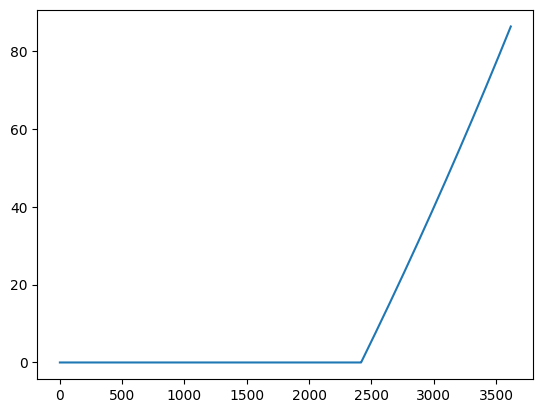

In [30]:
import matplotlib.pyplot as plt

plt.plot(value)
plt.show()